# MSE 211 MDP Project

We can do the project here

In [2]:
from abc import abstractmethod
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class SimpleGame:
    def __init__(self):
        self.actions = (0, 1)
        self.states = (0, 1, 2, 3, 4)
        self.rewards = [-1, -1, 10, -1, -1]
        self.gamma = 0.9
        self.probs = [
                [[0.9, 0.1], [0.1, 0.9], [0, 0], [0, 0], [0, 0]],
                [[0.9, 0.1], [0, 0], [0.1, 0.9], [0, 0], [0, 0]],
                [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0]],
                [[0, 0], [0, 0], [0.9, 0.1], [0, 0], [0.1, 0.9]],
                [[0, 0], [0, 0], [0, 0], [0.9, 0.1], [0.1, 0.9]],
            ]
        self.V = [0, 0, 0, 0, 0]

In [4]:
class IValueIteration:
    def __init__(self, game, sample_rate=1):
        self.game = game
        self.sample_rate = sample_rate

    @abstractmethod
    def run(self, V_new):
        raise NotImplemented

class ClassicValueIteration(IValueIteration):
    def run(self, V_new):
        delta = 0
        for s in self.game.states:
            max_val = 0
            for a in self.game.actions:
                val = self.game.rewards[s]
                for s_next in self.game.states:
                    val += self.game.probs[s][s_next][a] * (self.game.gamma * self.game.V[s_next])
                max_val = max(max_val, val)
            V_new[s] = max_val
            delta = max(delta, abs(self.game.V[s] - V_new[s]))
        self.game.V = V_new
        return delta

class RandomValueIteration(IValueIteration):
    def run(self, V_new):
        delta = 0
        # rather than go through all state values in each iteration
        # randomly select a subset of states
        sampled_states = random.sample(self.game.states, int(self.sample_rate * len(self.game.states)))
        for s in sampled_states:
            max_val = 0
            for a in self.game.actions:
                val = self.game.rewards[s]
                for s_next in sampled_states:
                    val += self.game.probs[s][s_next][a] * (self.game.gamma * self.game.V[s_next])
                max_val = max(max_val, val)
            V_new[s] = max_val
            delta = max(delta, abs(self.game.V[s] - V_new[s]))
        V = V_new
        return delta

class CyclicValueIteration(IValueIteration):
    def run(self, V_new):
        delta = 0
        for s in self.game.states:
            max_val = 0
            v = self.game.V[s]
            for a in self.game.actions:
                val = self.game.rewards[s]
                for s_next in self.game.states:
                    val += self.game.probs[s][s_next][a] * (self.game.gamma * self.game.V[s_next])
                max_val = max(max_val, val)
            self.game.V[s] = max_val
            delta = max(delta, abs(v - self.game.V[s]))
        return delta

class RandomCyclicValueIteration(IValueIteration):
    def run(self, V_new):
        delta = 0
        # rather than go through all state values in each iteration
        # randomly select a subset of states
        sampled_states = random.sample(self.game.states, int(self.sample_rate * len(self.game.states)))
        for s in sampled_states:
            max_val = 0
            v = self.game.V[s]
            for a in self.game.actions:
                val = self.game.rewards[s]
                for s_next in sampled_states:
                    val += self.game.probs[s][s_next][a] * (self.game.gamma * self.game.V[s_next])
                max_val = max(max_val, val)
            self.game.V[s] = max_val
            delta = max(delta, abs(v - self.game.V[s]))
        return delta

# of iterations: 1


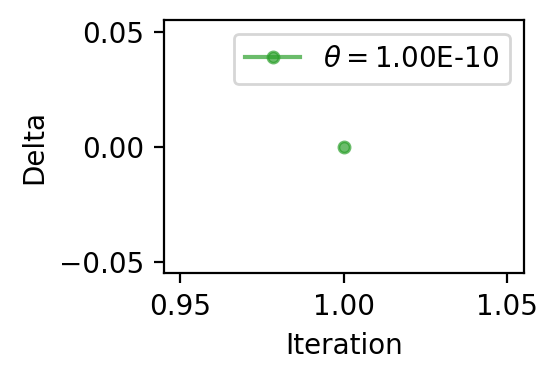

In [7]:
class VISimulation:
    def __init__(self, method):
        self.method = method

    def simulate(self, max_iter, theta):
        res = []
        iter = 0
        V = [0, 0, 0, 0, 0]
        while iter < max_iter:
            V_new = [0, 0, 0, 0, 0]
            delta = self.method.run(V_new)
            V = V_new
            res.append(delta)
            if delta < theta:
                break
            iter += 1

        print(f'# of iterations: {len(res)}')
        fig, ax = plt.subplots(1, 1, figsize=(3, 2), dpi=200)
        ax.plot(np.arange(len(res)) + 1, res, marker='o', markersize=4,
                alpha=0.7, color='#2ca02c', label=r'$\theta= $' + "{:.2E}".format(theta))
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Delta')
        ax.legend()
        plt.tight_layout()
        plt.show()

        return res

# m = ClassicValueIteration(SimpleGame())
# m = RandomValueIteration(SimpleGame(), sample_rate=0.8)
# m = CyclicValueIteration(SimpleGame())
m = RandomCyclicValueIteration(SimpleGame(), sample_rate=0.8)

res = VISimulation(m).simulate(10000, 1e-10)

In [83]:
# Q5: Tic-tac-toe

class TicTacToe:
    def __init__(self):
        # init the board
        self.board = [['-'] * 3 for _ in range(3)]
        self.is_over = False
        self.remaining_pos = {(i, j) for i in range(3) for j in range(3)}

    def __str__(self):
        s = ""
        size = len(self.board)
        for row in range(size):
            for col in range(size):
                s += self.board[row][col]
                if col == 2:
                    s += "\n"
        return s

    def mark(self, player, i, j):
        if self.is_over:
            raise Exception("Game is over.")
        if i < 0 or j < 0 or i > 2 or j > 2:
            raise Exception(f"({i}, {j}) is out of boundary.")
        if self.board[i][j] != '-':
            raise Exception(f"({i}, {j}) is taken.")

        self.board[i][j] = player.mark
        self.remaining_pos.remove((i, j))
        if self._is_over(player, i, j):
            return f"Game over. Winer is {player}."

        if len(self.remaining_pos) <= 0:
            return "Tie."

        return "Game is not over. Continue."

    def _is_over(self, player, i, j):
        # horizontally
        is_over = True
        for k in range(3):
            is_over &= self.board[k][j] == player.mark        

        # vertically
        is_over = True
        for k in range(3):
            is_over &= self.board[i][k] == player.mark
        
        # diagonally
        if i == j:
            is_over = True
            for k in range(3):
                is_over &= self.board[k][k] == player.mark

        diagonal = ((0, 2), (1, 1), (2, 0))
        if (i, j) in diagonal:
            is_over = True
            for k in diagonal:
                is_over &= self.board[k[0]][k[1]] == player.mark

        self.is_over = is_over
        return is_over        

class Player:
    def __init__(self, name, mark):
        self.name = name
        self.mark = mark

    def __str__(self):
        return f"Player {self.name}"


In [88]:
b = TicTacToe()
p1 = Player(1, "O")
p2 = Player(2, "X")

b.mark(p1, 1, 1)
b.mark(p2, 0, 1)
b.mark(p1, 0, 0)
b.mark(p2, 2, 1)
print(b.mark(p1, 2, 2))
print(b)

Game over. Winer is Player 1.
OX-
-O-
-XO



In [ ]:
import random
from Enum import enum
from abc import ABC, abstractmethod 
# States
# Actions

# State[action] => Prob To new States
dynamics = {
    1: {
        "A1": {
            1: 0,
            2: 0.5,
            3: 0.6
        }
    }
}


# States 
# Actions
# Rewards
class UpdateRule(Enum):
    DURING_SWEEP = "DURING SWEEP"
    AFTER_SWEEP = "AFTER SWEEP"

class ValueIterator(ABC):
    def __init__(self, update_rule: UpdateRule):
        self.update_rule = update_rule

    @abstractmethod
    def get_states(self, states, **kwargs):
        pass

    @abc.abstractproperty
    def update_rule(self):
        pass

    
    def iterate(self, mdp, states, reward, gamma, V_0):
        V = V_0
        V_copy = None if self.update_rule != UpdateRule.AFTER_SWEEP else V_0 # Deep Copy
        
        # If update during sweep, use the same v
        # If not updating during sweep, store and update later
        
        for state in self.get_states(states):
            costs = []
            for action in state.actions:
                state_action_cost = reward(state, action) + gamma * mdp.prob(s, a) * V[s, a]

                costs.append(state_action_cost)

            new_cost = max(costs)
            
            if self.update_rule == UpdateRule.DURING_SWEEP:
                V[state] = new_cost
                
            elif self.update_rule == UpdateRule.AFTER_SWEEP:
                V_copy[state] = new_cost

        # Return values at the end
        if self.update_rule == UpdateRule.AFTER_SWEEP:
            return V_copy
        elif self.update_rule == UpdateRule.DURING_SWEEP:
            return V



class ClassicVI(ValueIterator):
    def get_states(self, states, **kwargs):
        return states

    @property
    def update_rule(self):
        return UpdateRule.AFTER_SWEEP

class RandomVI(ValueIterator):
    def __init__(self, k):
        super().__init__()
        self.k = k
    
    def get_state(self, states, **kwargs):
        return random.sample(states, k)

    @property
    def update_rule(self):
        return UpdateRule.AFTER_SWEEP

class CyclicVI(ValueIterator):
    def get_state(self, states, **kwargs):
        return states

    @property
    def update_rule(self):
        return UpdateRule.DURING_SWEEP

class RandomCyclicVI(ValueIterator):
    def get_state(self, states, **kwargs):
        return random.sample(states)

    @property
    def update_rule(self):
        return UpdateRule.DURING_SWEEP


In [ ]:
"""
MDPSolver:

Model/MDP
Iteration Method

Iterate until end

"""

"""
Iteration method:
Classic VI,
Random VI
Cyclic VI,
Random Cyclic VI

All iteration methods:
Take states, actions, rewards, gamma, initial values

Ouptuts
new values vector for each state
"""


"""class MDP:


    def iterate(self):
        # Get stored values
        for state in self.states:
            
            vals = []
            for action in state.actions:
                value_cost = reward(state, action) + self.gamma * self.prob * value(state, action)
                vals.append(value_cost)

            value[state] = max(vals)
        # Update all values after state is stored


    def iterate_random_VI(self, k):
        states = random.sample(self.states, k)

        for state in self.states:
            vals = []
            for action in state.actions:
                value_cost = reward(state, action) + self.gamma * self.prob * value(state, action)
                vals.append(value_cost)

            value[state] = max(vals)
        # Update all values after state is stored


    def iterate_cyclic_VI(self):
        # Get stored values
        for state in self.states:
            
            vals = []
            for action in state.actions:
                value_cost = reward(state, action) + self.gamma * self.prob * value(state, action)
                vals.append(value_cost)

            # Update stored values
            value[state] = max(vals)


    def iterate_cyclic_VI_random(self):
        # Get stored values
        for state in random.sample(self.states):
            
            vals = []
            for action in state.actions:
                value_cost = reward(state, action) + self.gamma * self.prob * value(state, action)
                vals.append(value_cost)

            # Update stored values
            value[state] = max(vals)


"""